# Make 3 versions of 4th Session assignment's best model :
> 1. Network with Group Normalization

> 2. Network with Layer Normalization

> 3. Network with L1 + BN


> Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include.

> Write a single notebook file to run all the 3 models above for 20 epochs each

> Create these graphs:
> 1. Graph 1: Test/Validation Loss for all 3 models together
> 2. Graph 2: Test/Validation Accuracy for 3 models together

> graphs must have proper annotation

> Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 25 19:13:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### For Importing the single model file named "model.py" under which model class named "EVA8_session4_assignment_model" is defined, with capabilities to have either of Batch/Layer/Group normalization, we have to put it as a package-element at the github (so that we can do a pip-install as below and can import it as a package element later on)

In [ ]:
!pip install git+https://git@github.com/ojhajayant/EVA8.git --upgrade 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/ojhajayant/EVA8.git to /tmp/pip-req-build-_vv0i96a
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/ojhajayant/EVA8.git' /tmp/pip-req-build-_vv0i96a
  Resolved https://****@github.com/ojhajayant/EVA8.git to commit a3a82086f39e93297bfbee2bd32774126ad203a3
  Preparing metadata (setup.py) ... done
  Created wheel for eva8: filename=eva8-0.0.0-py3-none-any.whl size=3221 sha256=13c89c20108e24af6e90c535b6c3a81bc9f746f67fa5d314ee2342a78ffe7bb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-15pwa9gt/wheels/91/2b/81/6528ca90c705fbe7f126306baa4c34cd2cbf0ea8fcb5a3dd90
Successfully built eva8


# Import Libraries

In [ ]:
from __future__ import print_function
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

### Now also import the single model file named "EVA8_session4_assignment_model" which has the best version of the 3 attempts made during the session 4 & on which we need to experiment with 3 combinations of Regularizations:

> 1. Network with Group Normalization
> 2. Network with Layer Normalization
> 3. Network with L1 + BN

In [ ]:
from session_5.modular.models import model

In [ ]:
best_acc1 = 0
tmp_best_acc1 = 0

### Optimum values found for L1-penalty-weight.
    - The appropriate values for l1  weights were found after coarsely sweeping thru values from 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001 first.
    - For l1-weight, with l1-alone enabled, the 0.00001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.00001 region, led to the value: 0.000025, which seems to be having best accuracy values.

In [ ]:
l1_weight = 0.000025 ##Appears to be the best with the reference NW we have used here

In [ ]:
class_names  = [ "zero",  # index 0
                 "one",   # index 1
                 "two",   # index 2 
                 "three", # index 3 
                 "four",  # index 4
                 "five",  # index 5
                 "six",   # index 6 
                 "seven", # index 7 
                 "eight", # index 8 
                 "nine"]  # index 9

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_mnist, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_mnist, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


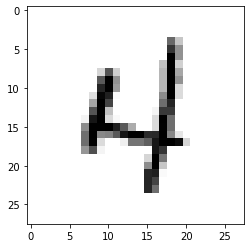

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_mnist.train_data
train_data = train_mnist.transform(train_data.numpy())
#train_data = train.train_data.cpu().numpy()

print('[Train]')
print(' - Numpy Shape:', train_mnist.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_mnist.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

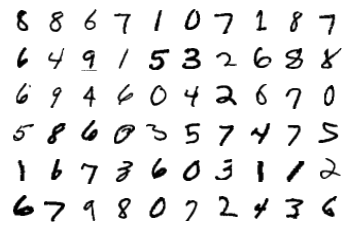

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training and Testing related routines

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
def l1_penalty(x):
    #L1 regularization adds an L1 penalty equal
    #to the absolute value of the magnitude of coefficients
    return torch.abs(x).sum()

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        #L1 regularization adds an L1 penalty equal to the 
        #absolute value of the magnitude of coefficients
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader, epoch, optimizer, Norm='batch', L1=False):
    global best_acc1, tmp_best_acc1
    model.eval()
    test_loss = 0
    correct = 0
    acc1 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc1 = 100. * correct / len(test_loader.dataset)
    is_best = acc1 > best_acc1
    tmp_best_acc1 = best_acc1
    best_acc1 = max(acc1, best_acc1)
    model_name = ''
    # Prepare model model saving directory.
    if is_best:
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        model_name = 'MNIST_model_epoch-{}_L1-{}_{}-Norm_val_acc-{:.2f}.h5'.format(epoch+1, int(L1), Norm, acc1) 
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        filepath = os.path.join(save_dir, model_name)
        print("validation-accuracy improved from {:.2f} to {:.2f}, saving model to {}".format(tmp_best_acc1, best_acc1, filepath))
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename=filepath)
    test_acc.append(100. * correct / len(test_loader.dataset))
    
    return model_name

### model-prediction & mislabelled image display related routines


In [ ]:
def model_pred(model, device, y_test, batchsize=test_mnist.data.cpu().numpy().shape[0]):
    from sklearn.metrics import confusion_matrix, classification_report
    model.eval()
    dataldr_args = dict(shuffle=False, batch_size=batchsize, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10000)
    test_ldr = torch.utils.data.DataLoader(test_mnist, **dataldr_args)
    with torch.no_grad():
        for data, target in test_ldr:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred = y_pred.cpu().numpy()
    print(confusion_matrix(y_test, y_pred.reshape(-1)))
    print('\n')
    print(classification_report(y_test, y_pred.reshape(-1), target_names=class_names))
    return y_pred


def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(30,9))
    fig.suptitle(title_str, fontsize=24)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            img_num = np.random.randint(features_idx.shape[0])
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(i) + ' Pred:{} '.format(y_pred[intsct[img_num]][0]), fontsize=20)
            plt.imshow(im)
    plt.show()

### routine to load any model from saved file

In [ ]:
def load_model(describe_model_nn, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    model = describe_model_nn #describe_model_nn is for example: Net1()
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    return  model

### routine to save & load the validation-accuracy & validation-loss data  for any model

In [ ]:
def save_acc_loss(test_losses, test_acc, test_loss_file_name,  test_acc_file_name):
    import os
    import numpy as np
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    print("\nsaving test_loss related numpy file to {}".format(filepath_test_loss))
    np.save(filepath_test_loss,test_losses)
    print("\nsaving test_acc related numpy file to {}".format(filepath_test_acc))
    np.save(filepath_test_acc,test_acc)
    

def load_acc_loss(test_loss_file_name,  test_acc_file_name):
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    print("\nloading test_loss related numpy file from {}".format(filepath_test_loss))
    loaded_test_losses = np.load(filepath_test_loss).tolist()
    print("\nloading test_acc related numpy file from {}".format(filepath_test_acc))
    loaded_test_acc = np.load(filepath_test_acc).tolist()
    return loaded_test_losses, loaded_test_acc

### routine to plot 3 accuracies and 3 losses in 2 separate plots (for:
> 1. Network with Group Normalization
> 2. Network with Layer Normalization
> 3. Network with L1 + BN

)

In [ ]:
def plot_curves(first_acc, second_acc, third_acc,
                first_loss, second_loss, third_loss):
    fig, axs = plt.subplots(1,2,figsize=(20,10))
    _= axs[0].plot(first_acc)
    _= axs[0].plot(second_acc)
    _= axs[0].plot(third_acc)
    _= axs[0].set_title('model test accuracies', fontsize=22)
    _= axs[0].set_ylabel('test-accuracy', fontsize=18)
    _= axs[0].set_xlabel('epoch', fontsize=18)
    _= axs[0].legend(['Network with Group Normalization', 'Network with Layer Normalization', 'Network with L1 + BN'], loc='upper left')
    _= axs[1].plot(first_loss)
    _= axs[1].plot(second_loss)
    _= axs[1].plot(third_loss)
    _= axs[1].set_title('model test losses', fontsize=22)
    _= axs[1].set_ylabel('test-loss', fontsize=18)
    _= axs[1].set_xlabel('epoch', fontsize=18)
    _= axs[1].legend(['Network with Group Normalization', 'Network with Layer Normalization', 'Network with L1 + BN'], loc='upper right')

# The model
Let's start with the model we first saw, the base-line/reference model being used here is as shown in the table below:
Taken from 3rd attempt from session_4, the network structure /architecture hasn't changed.except, the capability to introduce either of Batch/Layer/Group normalization optionally (obviously in a mutually exclusive way)
Hence, an architecture as shown in the table below is still chosen as a "baseline" one.Same description as given under that session_4 attempt is extended here too.
As while solving the earlier session assignment (and also as covered thoroughly in the last "coding-drill-down" session) two architectural components: BatchNorm & DropOut came out to be two important components to be applied on any Conv2d-layer (except the last one), hence for this session assignment, with very limited number of attempts to go thru (i.e. exactly 3 steps), starting out with inclusion of both these components under this 1st "baseline" neural network architecture (as mentioned before, the excercises on effects of gradual inclusion of both components on neural-net performance, was already undertaken while solving the earlier assignment, hence feel fair enough to start out the first attempt architecture, with both of them included under this new "baseline")

Here is the layering, which is being used to achieve the receptive-field and parameter targets.

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x10`   |      `26x26x10`  |      `3x3`  **INPUT BLOCK** [actually just one conv2d 3x3 layer(image-conv2d layer)]    
` `              | `BN(10)`   |      ` `  |      ` `
` `              | `Dropout(2.9%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
`26x26x10`             | `(3x3x10)x10`  |      `24x24x10` |      `5x5`     **CONVOLUTION BLOCK 1** [1st conv2d 3x3 layer for this block ]
` `              | `BN(10)`   |      ` `  |      ` `
` `              | `Dropout(2.9%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
`24x24x10`             | `(3x3x10)x15`  |      `22x22x15` |      `7x7`     **CONVOLUTION BLOCK 1** [2nd conv2d 3x3 layer for this block ]
` `              | `BN(15)`   |      ` `  |      ` `
` `              | `Dropout(2.9%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
**22x22x15**             |   **MP(2x2)**    |     **11x11x15**   |     **8x8**  **TRANSITION BLOCK 1**  [1st maxpool(2,2) layer for this block]                     
**11x11x15**             | **(1x1x15)x10**  |     **11x11x10**   |      **8x8**  **TRANSITION BLOCK 1**  [2nd 1 conv2d 1x1 layer for this block]  
** **             | **BN(10)**   |     ** **  |     ** **                    
** **             | **Dropout(2.9%)**   |     ** **  |     ** **
** **             | **ReLU**   |     ** **  |     ** **      
*11x11x10*             | *(3x3x10)x10*  |      *9x9x10* |      *12x12*  **CONVOLUTION BLOCK 2** [1st conv2d 3x3 layer for this block]
** **            | *BN(10)*   |     * *   |     * * 
** **             | *Dropout(2.9%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **                       
*9x9x10*             | *(3x3x10)x10*  |      *7x7x10* |      *16x16*  **CONVOLUTION BLOCK 2** [2nd conv2d 3x3 layer for this block] 
** **            | *BN(16)*   |     * *   |     * * 
** **             | *Dropout(2.9%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **    
*7x7x10*               | *(3x3x10)x32*  |      *5x5x32*  |      *20x20*  **CONVOLUTION BLOCK 2** [3rd conv2d 3x3 layer for this block, this 32 number of output channels at this stage provides a CAPACITY BOOST for the overall network as explained ahead]  
** **            | *BN(32)*   |     * *   |     * * 
** **             | *Dropout(2.9%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **   
5x5x32               | GAP  LAYER (kernel_size=(5,5)   |      1x1x32          | `28x28` (20 + (5-1)x2 = 28) **OUTPUT BLOCK** [GAP layer]
`1x1x32`               | `(1x1x32)x10`  |      `1x1x10`    |      `28x28` (28 + (1-1)x10 = 28) **OUTPUT BLOCK** [1 conv2d 1x1 layer]
` `             | `log_SoftMax`   |     ` `  |     ` ` 

 above has 4 "components":
 
 1. **INPUT BLOCK:** One initial, "Input Block" at the begining, to convolve over the "original image"  channel(s), due to the opposing constraints of meeting an accuracy number with lesser parameters possible,
    choosing  10 number of kernels for this 'separate' layer (which feeds in to the next "CONVOLUTION BLOCK 1",
    explained below).This 1 initial layer & two following layers (under "CONVOLUTION BLOCK 1") provide receptive
    field of 7x7 pixels(3->5->7) sufficient for the MNIST dataset's edges & gradient generation.No padding used.    
	
 2. **CONVOLUTION BLOCK 1:** placed after the first "Input Block" layer, 2 layers of 3x3 conv2d operators, with 10 & 15 o/p channels at   each layer position respectively.Thus providing 15 channels at the output.No padding used.
    
 3. **TRANSITION BLOCK 1:** max-pool(k=2,s=2) and a-1x1-feature-merger kernel, following the 'CONVOLUTION BLOCK 1'.Provides 10 o/p channels.No padding used.
    
 4. **CONVOLUTION BLOCK 2:** These are 3 layers of 3x3 conv2d operators, with 10, 10, 32 o/p channels at  each layer position respectively.Here point to be noted, is the use of a "capacity boosting" number of o/p channels at the end. (reason explained in the next point below)
  
 5. **OUTPUT BLOCK:**: GAP layer followed by a 1x1 operator (which actually resembles a fully-connected(FC) layer in this case. A noteworthy point (which relates to the "capacity" element of the overall netowrk (NW)) is that the FC (the 1x1 conv2d behaviour here) will work better, in generating the final 10 "class-features" to be used by the log_softmax.If the inputs to it, have more "features points", i.e. for example if we do a 16->10 conversion, vs a 32->10 conversion, we can expect the 10 class-features (for softmax to decide)      generated by a 32->10 conversion will be more "robust" (as compared to say a 16->10 conversion)
     Forunately, with an already "frugal" choice of numbers like 10, 15 etc, made for earlier layer (and also "frugality" in the total number of layers, which still provide an overall RF as 28, i.e. at least just equal to the original image/object size in this case), we can go ahead with choosing 32 here.

Given below is the number of parameters thus obtained, which is well under 8k.

#####======================= 

> Total params: 7,684

> Trainable params: 7,684

> Non-trainable params: 0
#####--------------------------------------------------

Also please note that out of all the other tested % ranges for dropout, it was found for this NW that 2.9% dropout worked best.


### Now Run 3 required iterations

In [ ]:
run_combinations_dict = { # this dictionary values are used as :
                          # for Norm, L1 in run_combinations_dict.items(): 
                          # so as to get respective "flag" value during
                          # each iteration (during 3 such iterations)
    'group': False,
    'layer': False,
    'batch': True
}

In [ ]:
def perform_iteration_tasks(device, mdl, Norm, L1):
  # Step 1: Instantiate a model (option-based)  & load to the device.
  print("Train & Test Neural Network With {}-Norm-Type & With L1-Regularization As: {}".format(Norm, L1))
  model = mdl.EVA8_session4_assignment_model(Norm)
  model = model.to(device)

  # Step 2: Get the model-summary for instantiated model from Step 1(option-based)
  print("\nModel Summary For Model With {}-Norm-Type & With L1-Regularization As: {}".format(Norm, L1))
  summary(model, input_size=(1, 28, 28))

  # Step 3: Setup the LR (based on the last session best model)
  EPOCHS = 20
  init_learning_rate = 0.07
  gamma= (init_learning_rate - (0.1/EPOCHS))/init_learning_rate
  optimizer = optim.SGD(model.parameters(), lr=init_learning_rate, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

  # Step 4: Train & Test the model for 20 epochs also get the best-model name 
  # for those 20 epochs
  last_best = ''
  for epoch in range(EPOCHS):
      print("\nEPOCH:", epoch+1)
      train(model, device, train_loader, optimizer, epoch, L1=L1)
      # Print Learning Rate
      print(' LR:', scheduler.get_last_lr())
      scheduler.step()
      model_name = test(model, device, test_loader, epoch, optimizer, Norm=Norm, L1=L1)
      last_best = last_best if (model_name == '') else model_name

  # Step 5: Save the validation-accuracy & validation-loss data for the model
  # in *npy format (to be used to draw 2 final consolidated loss and accuracy
  # plots for all 3 iterations thru 3 model types)
  save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_{}-Norm.npy'.format(int(L1), Norm),
              test_acc_file_name='test_acc_l1_{}_{}-Norm.npy'.format(int(L1), Norm)
             )
  
  # Step 6: Now load the best model from this iteration
  print('With {}-Norm-Type & With L1-Regularization As: {}, BEST MODEL IS: {}, '.format(Norm, L1, last_best))
  model = load_model(model, model_name=last_best)

  # Step 7: Get Confusion Matrix & Classification-Report for this model's prdections
  print("\nConfusion matrix & Classification Report For Model With {}-Norm-Type & With L1-Regularization As: {}\n".format(Norm, L1))
  y_test = test_mnist.targets.cpu().numpy()
  y_pred = model_pred(model, device, y_test)

  
  # Step 8: Draw the individual loss/accuracy plots for that 20 epochs 
  print("\nIndvidual Loss/Accuracy Plot For Model With {}-Norm-Type & With L1-Regularization As: {}\n".format(Norm, L1))
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  trn_loss= [t.cpu().item() for t in train_losses]
  axs[0, 0].plot(trn_loss)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc[4000:])
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

  # Step 9: Get few mislabelled images from the model
  x_test = test_mnist.data.cpu().numpy()
  display_mislabelled(model, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual, For Model With {}-Norm-Type & With L1-Regularization As: {}'.format(Norm, L1) )



			ITERATION NO: 1: Norm=group, L1=False

 cuda
Train & Test Neural Network With group-Norm-Type & With L1-Regularization As: False

Model Summary For Model With group-Norm-Type & With L1-Regularization As: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
         GroupNorm-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
         GroupNorm-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
        GroupNorm-10           [-1, 15, 22, 22]              30
          Dropout

Loss=0.0684753805398941 Batch_id=937 Accuracy=90.77: 100%|██████████| 938/938 [00:20<00:00, 46.36it/s]

 LR: [0.07]



Test set: Average loss: 0.0801, Accuracy: 9744/10000 (97.44%)

validation-accuracy improved from 0.00 to 97.44, saving model to /content/saved_models/MNIST_model_epoch-1_L1-0_group-Norm_val_acc-97.44.h5

EPOCH: 2


Loss=0.1831999570131302 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:20<00:00, 46.48it/s]

 LR: [0.065]



Test set: Average loss: 0.0488, Accuracy: 9857/10000 (98.57%)

validation-accuracy improved from 97.44 to 98.57, saving model to /content/saved_models/MNIST_model_epoch-2_L1-0_group-Norm_val_acc-98.57.h5

EPOCH: 3


Loss=0.018023721873760223 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:19<00:00, 48.14it/s]

 LR: [0.06035714285714285]



Test set: Average loss: 0.0343, Accuracy: 9896/10000 (98.96%)

validation-accuracy improved from 98.57 to 98.96, saving model to /content/saved_models/MNIST_model_epoch-3_L1-0_group-Norm_val_acc-98.96.h5

EPOCH: 4


Loss=0.028863724321126938 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:21<00:00, 43.80it/s]


 LR: [0.05604591836734693]

Test set: Average loss: 0.0404, Accuracy: 9868/10000 (98.68%)


EPOCH: 5


Loss=0.011618787422776222 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:19<00:00, 47.37it/s]

 LR: [0.052042638483965]



Test set: Average loss: 0.0352, Accuracy: 9888/10000 (98.88%)


EPOCH: 6


Loss=0.0009318799711763859 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:19<00:00, 48.35it/s]

 LR: [0.04832530716368178]



Test set: Average loss: 0.0315, Accuracy: 9897/10000 (98.97%)

validation-accuracy improved from 98.96 to 98.97, saving model to /content/saved_models/MNIST_model_epoch-6_L1-0_group-Norm_val_acc-98.97.h5

EPOCH: 7


Loss=0.007305670529603958 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:19<00:00, 48.29it/s]

 LR: [0.04487349950913308]



Test set: Average loss: 0.0314, Accuracy: 9888/10000 (98.88%)


EPOCH: 8


Loss=0.1258775293827057 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:19<00:00, 48.32it/s]

 LR: [0.041668249544195]



Test set: Average loss: 0.0302, Accuracy: 9912/10000 (99.12%)

validation-accuracy improved from 98.97 to 99.12, saving model to /content/saved_models/MNIST_model_epoch-8_L1-0_group-Norm_val_acc-99.12.h5

EPOCH: 9


Loss=0.020813941955566406 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:19<00:00, 48.66it/s]

 LR: [0.03869194600532393]



Test set: Average loss: 0.0316, Accuracy: 9898/10000 (98.98%)


EPOCH: 10


Loss=0.0015026637120172381 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:22<00:00, 41.86it/s]

 LR: [0.03592823557637222]



Test set: Average loss: 0.0275, Accuracy: 9914/10000 (99.14%)

validation-accuracy improved from 99.12 to 99.14, saving model to /content/saved_models/MNIST_model_epoch-10_L1-0_group-Norm_val_acc-99.14.h5

EPOCH: 11


Loss=0.0021108088549226522 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:19<00:00, 47.12it/s]

 LR: [0.03336193303520277]



Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

validation-accuracy improved from 99.14 to 99.21, saving model to /content/saved_models/MNIST_model_epoch-11_L1-0_group-Norm_val_acc-99.21.h5

EPOCH: 12


Loss=0.011342494748532772 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:20<00:00, 45.51it/s]

 LR: [0.030978937818402566]



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

validation-accuracy improved from 99.21 to 99.28, saving model to /content/saved_models/MNIST_model_epoch-12_L1-0_group-Norm_val_acc-99.28.h5

EPOCH: 13


Loss=0.0015586433000862598 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:19<00:00, 48.97it/s]

 LR: [0.028766156545659522]



Test set: Average loss: 0.0242, Accuracy: 9918/10000 (99.18%)


EPOCH: 14


Loss=0.005094034597277641 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:19<00:00, 47.80it/s]

 LR: [0.02671143107811241]



Test set: Average loss: 0.0236, Accuracy: 9931/10000 (99.31%)

validation-accuracy improved from 99.28 to 99.31, saving model to /content/saved_models/MNIST_model_epoch-14_L1-0_group-Norm_val_acc-99.31.h5

EPOCH: 15


Loss=0.0014597784029319882 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:19<00:00, 48.34it/s]

 LR: [0.02480347171539009]



Test set: Average loss: 0.0266, Accuracy: 9918/10000 (99.18%)


EPOCH: 16


Loss=0.013520956039428711 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:19<00:00, 48.33it/s]


 LR: [0.023031795164290797]

Test set: Average loss: 0.0258, Accuracy: 9926/10000 (99.26%)


EPOCH: 17


Loss=0.0034973372239619493 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:19<00:00, 47.11it/s]

 LR: [0.021386666938270023]



Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)


EPOCH: 18


Loss=0.012720396742224693 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:19<00:00, 48.52it/s]

 LR: [0.019859047871250732]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)


EPOCH: 19


Loss=0.04799576476216316 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:20<00:00, 46.12it/s]

 LR: [0.01844054445187568]



Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)


EPOCH: 20


Loss=0.0030279275961220264 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:19<00:00, 47.94it/s]

 LR: [0.01712336270531313]



Test set: Average loss: 0.0250, Accuracy: 9916/10000 (99.16%)


saving test_loss related numpy file to /content/saved_data/test_loss_l1_0_group-Norm.npy

saving test_acc related numpy file to /content/saved_data/test_acc_l1_0_group-Norm.npy
With group-Norm-Type & With L1-Regularization As: False, BEST MODEL IS: MNIST_model_epoch-14_L1-0_group-Norm_val_acc-99.31.h5, 

Confusion matrix & Classification Report For Model With group-Norm-Type & With L1-Regularization As: False

[[ 974    0    0    0    0    0    4    1    0    1]
 [   0 1128    1    0    0    2    3    0    1    0]
 [   1    0 1027    0    0    0    1    3    0    0]
 [   0    0    1 1005    0    4    0    0    0    0]
 [   0    0    0    0  973    0    1    1    1    6]
 [   1    0    0    5    0  884    1    1    0    0]
 [   1    1    1    0    1    1  952    0    1    0]
 [   0    3    2    1    0    0    0 1021    0    1]
 [   0    0    2    0    1    2    0    0  968    1]
 [   1    0    1    1    2    0    1    3   

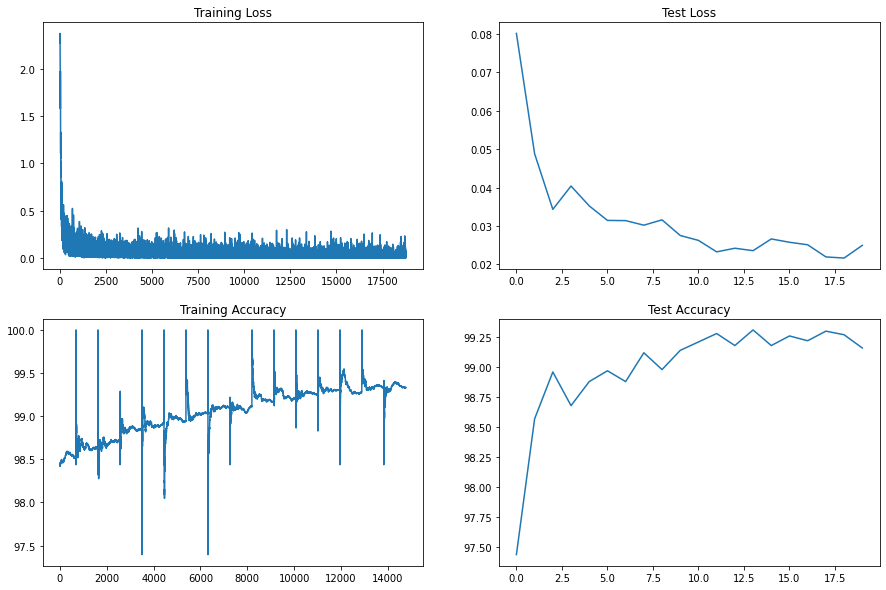

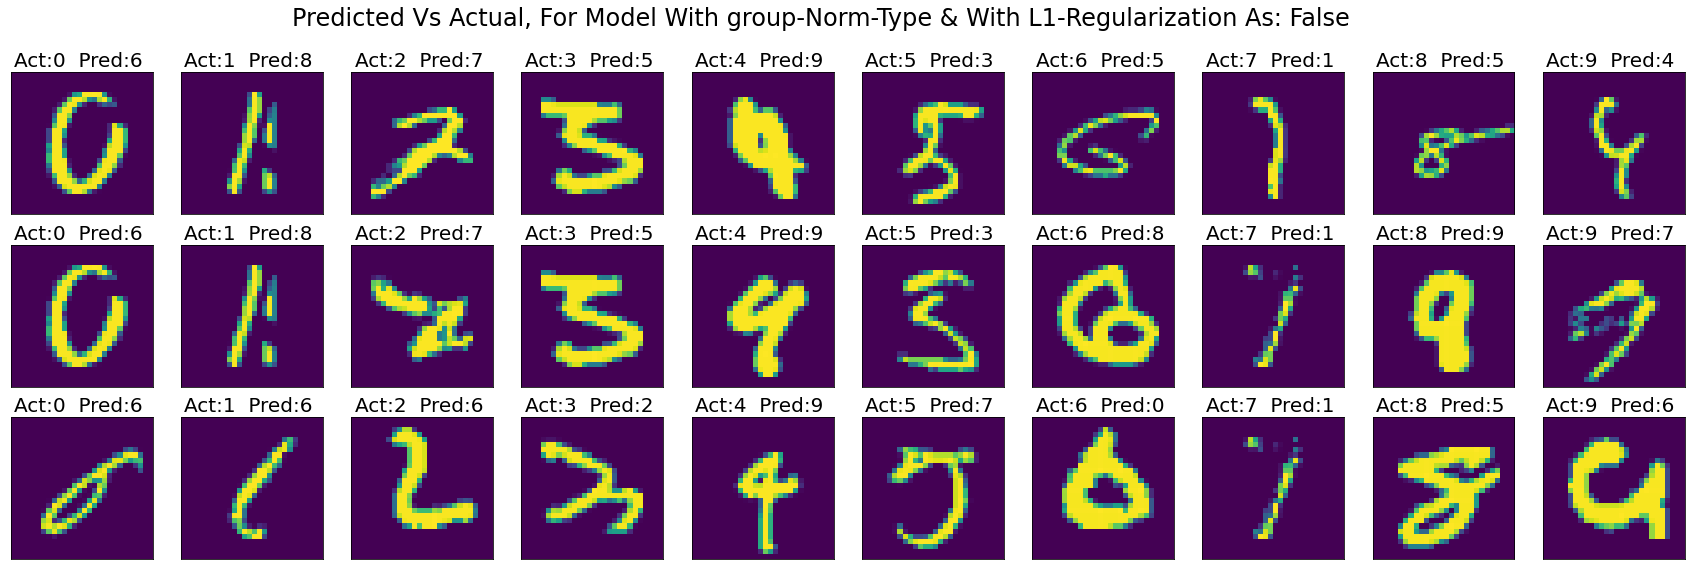


			ITERATION NO: 2: Norm=layer, L1=False

 cuda
Train & Test Neural Network With layer-Norm-Type & With L1-Regularization As: False

Model Summary For Model With layer-Norm-Type & With L1-Regularization As: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
         LayerNorm-2           [-1, 10, 26, 26]          13,520
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
         LayerNorm-6           [-1, 10, 24, 24]          11,520
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
        LayerNorm-10           [-1, 15, 22, 22]          14,520
          Dropout

Loss=0.1123424768447876 Batch_id=937 Accuracy=88.60: 100%|██████████| 938/938 [00:22<00:00, 42.46it/s]

 LR: [0.07]



Test set: Average loss: 0.0902, Accuracy: 9739/10000 (97.39%)

validation-accuracy improved from 0.00 to 97.39, saving model to /content/saved_models/MNIST_model_epoch-1_L1-0_layer-Norm_val_acc-97.39.h5

EPOCH: 2


Loss=0.039060138165950775 Batch_id=937 Accuracy=96.98: 100%|██████████| 938/938 [00:20<00:00, 45.01it/s]

 LR: [0.065]



Test set: Average loss: 0.0588, Accuracy: 9808/10000 (98.08%)

validation-accuracy improved from 97.39 to 98.08, saving model to /content/saved_models/MNIST_model_epoch-2_L1-0_layer-Norm_val_acc-98.08.h5

EPOCH: 3


Loss=0.047605231404304504 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:20<00:00, 45.19it/s]

 LR: [0.06035714285714285]



Test set: Average loss: 0.0535, Accuracy: 9835/10000 (98.35%)

validation-accuracy improved from 98.08 to 98.35, saving model to /content/saved_models/MNIST_model_epoch-3_L1-0_layer-Norm_val_acc-98.35.h5

EPOCH: 4


Loss=0.033153317868709564 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:20<00:00, 44.69it/s]


 LR: [0.05604591836734693]

Test set: Average loss: 0.0444, Accuracy: 9853/10000 (98.53%)

validation-accuracy improved from 98.35 to 98.53, saving model to /content/saved_models/MNIST_model_epoch-4_L1-0_layer-Norm_val_acc-98.53.h5

EPOCH: 5


Loss=0.018955236300826073 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:20<00:00, 45.23it/s]

 LR: [0.052042638483965]



Test set: Average loss: 0.0389, Accuracy: 9875/10000 (98.75%)

validation-accuracy improved from 98.53 to 98.75, saving model to /content/saved_models/MNIST_model_epoch-5_L1-0_layer-Norm_val_acc-98.75.h5

EPOCH: 6


Loss=0.20833784341812134 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:21<00:00, 44.51it/s]

 LR: [0.04832530716368178]



Test set: Average loss: 0.0366, Accuracy: 9882/10000 (98.82%)

validation-accuracy improved from 98.75 to 98.82, saving model to /content/saved_models/MNIST_model_epoch-6_L1-0_layer-Norm_val_acc-98.82.h5

EPOCH: 7


Loss=0.014212483540177345 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:20<00:00, 44.99it/s]


 LR: [0.04487349950913308]

Test set: Average loss: 0.0319, Accuracy: 9900/10000 (99.00%)

validation-accuracy improved from 98.82 to 99.00, saving model to /content/saved_models/MNIST_model_epoch-7_L1-0_layer-Norm_val_acc-99.00.h5

EPOCH: 8


Loss=0.001295437105000019 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:21<00:00, 43.04it/s]

 LR: [0.041668249544195]



Test set: Average loss: 0.0290, Accuracy: 9902/10000 (99.02%)

validation-accuracy improved from 99.00 to 99.02, saving model to /content/saved_models/MNIST_model_epoch-8_L1-0_layer-Norm_val_acc-99.02.h5

EPOCH: 9


Loss=0.014306539669632912 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:21<00:00, 42.89it/s]


 LR: [0.03869194600532393]

Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

validation-accuracy improved from 99.02 to 99.14, saving model to /content/saved_models/MNIST_model_epoch-9_L1-0_layer-Norm_val_acc-99.14.h5

EPOCH: 10


Loss=0.006826265249401331 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:21<00:00, 44.34it/s]

 LR: [0.03592823557637222]



Test set: Average loss: 0.0271, Accuracy: 9912/10000 (99.12%)


EPOCH: 11


Loss=0.006336608901619911 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:21<00:00, 44.21it/s]


 LR: [0.03336193303520277]

Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)


EPOCH: 12


Loss=0.007795603480190039 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:21<00:00, 44.42it/s]

 LR: [0.030978937818402566]



Test set: Average loss: 0.0258, Accuracy: 9914/10000 (99.14%)


EPOCH: 13


Loss=0.07446274906396866 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:21<00:00, 44.49it/s]

 LR: [0.028766156545659522]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

validation-accuracy improved from 99.14 to 99.25, saving model to /content/saved_models/MNIST_model_epoch-13_L1-0_layer-Norm_val_acc-99.25.h5

EPOCH: 14


Loss=0.012167995795607567 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:21<00:00, 44.54it/s]

 LR: [0.02671143107811241]



Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

validation-accuracy improved from 99.25 to 99.27, saving model to /content/saved_models/MNIST_model_epoch-14_L1-0_layer-Norm_val_acc-99.27.h5

EPOCH: 15


Loss=0.02219056896865368 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:21<00:00, 44.04it/s]

 LR: [0.02480347171539009]



Test set: Average loss: 0.0225, Accuracy: 9918/10000 (99.18%)


EPOCH: 16


Loss=0.001537117874249816 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:22<00:00, 42.36it/s]

 LR: [0.023031795164290797]



Test set: Average loss: 0.0270, Accuracy: 9917/10000 (99.17%)


EPOCH: 17


Loss=0.003338542999699712 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:21<00:00, 42.93it/s]

 LR: [0.021386666938270023]



Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)


EPOCH: 18


Loss=0.013434764929115772 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:21<00:00, 44.58it/s]


 LR: [0.019859047871250732]

Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

validation-accuracy improved from 99.27 to 99.32, saving model to /content/saved_models/MNIST_model_epoch-18_L1-0_layer-Norm_val_acc-99.32.h5

EPOCH: 19


Loss=0.0007214942597784102 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:20<00:00, 44.72it/s]

 LR: [0.01844054445187568]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)


EPOCH: 20


Loss=0.0006112228729762137 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:20<00:00, 45.03it/s]

 LR: [0.01712336270531313]



Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

validation-accuracy improved from 99.32 to 99.33, saving model to /content/saved_models/MNIST_model_epoch-20_L1-0_layer-Norm_val_acc-99.33.h5

saving test_loss related numpy file to /content/saved_data/test_loss_l1_0_layer-Norm.npy

saving test_acc related numpy file to /content/saved_data/test_acc_l1_0_layer-Norm.npy
With layer-Norm-Type & With L1-Regularization As: False, BEST MODEL IS: MNIST_model_epoch-20_L1-0_layer-Norm_val_acc-99.33.h5, 

Confusion matrix & Classification Report For Model With layer-Norm-Type & With L1-Regularization As: False

[[ 975    0    1    0    0    0    2    1    1    0]
 [   0 1132    1    0    0    1    0    1    0    0]
 [   1    1 1026    1    0    0    1    1    0    1]
 [   0    0    1 1004    0    3    0    1    1    0]
 [   0    0    0    0  975    0    1    0    0    6]
 [   1    0    0    3    0  887    1    0    0    0]
 [   5    3    0    0    0    3  947    0    0    0]
 [   0  

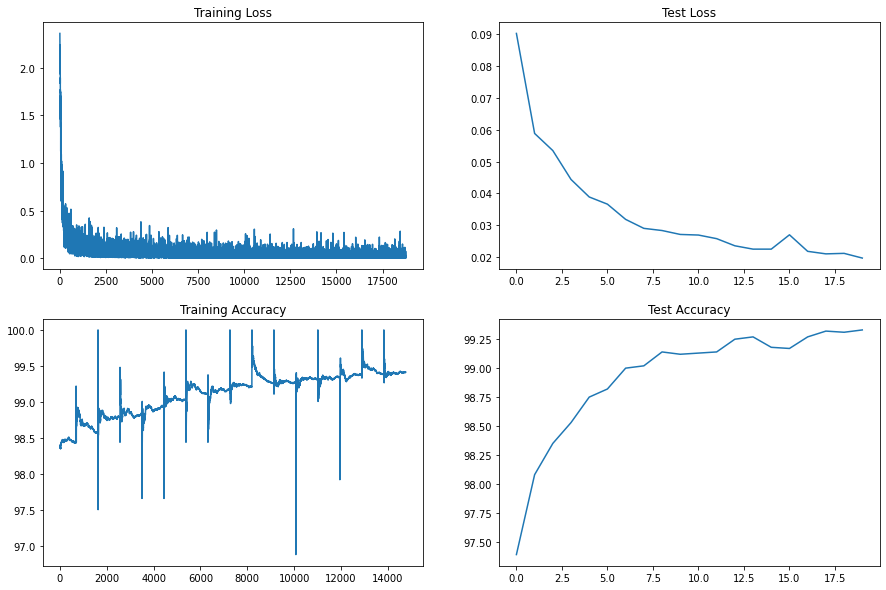

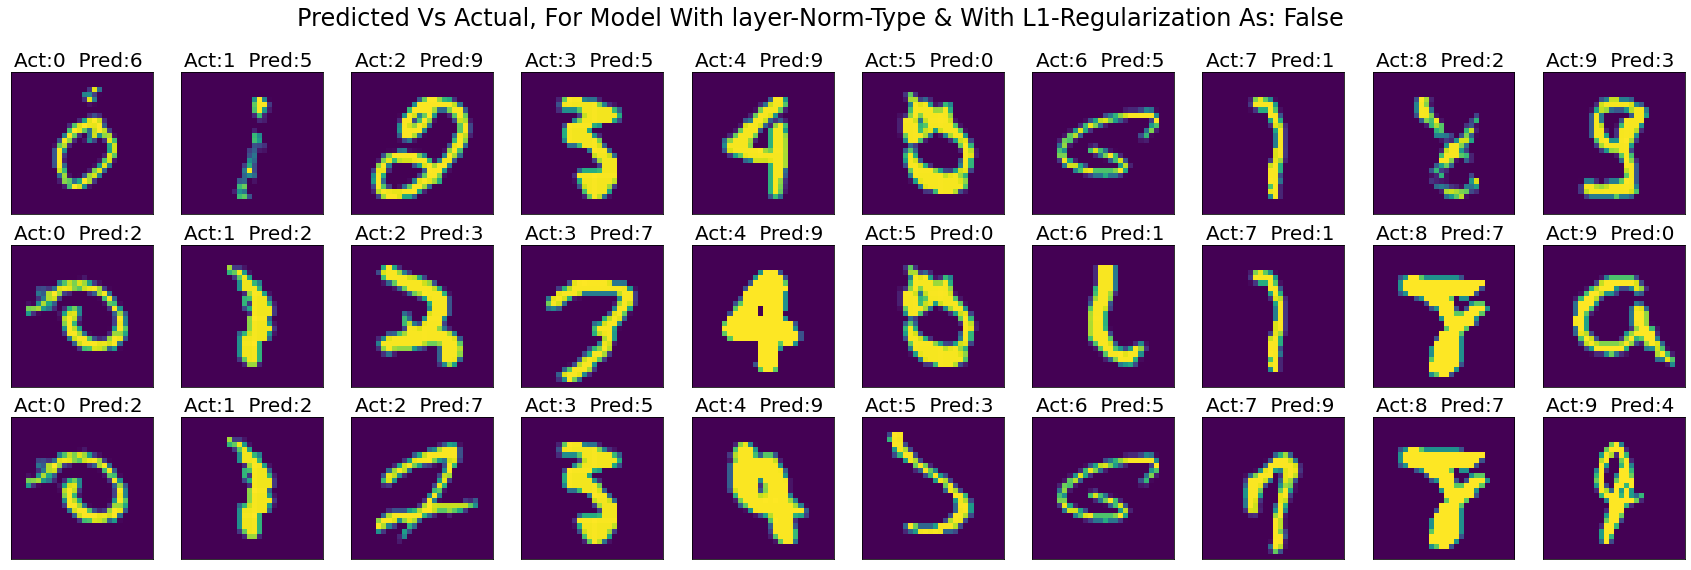


			ITERATION NO: 3: Norm=batch, L1=True

 cuda
Train & Test Neural Network With batch-Norm-Type & With L1-Regularization As: True

Model Summary For Model With batch-Norm-Type & With L1-Regularization As: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
          Dropout-11

Loss=0.16603927314281464 Batch_id=937 Accuracy=94.02: 100%|██████████| 938/938 [00:23<00:00, 40.26it/s]

 LR: [0.07]



Test set: Average loss: 0.0458, Accuracy: 9849/10000 (98.49%)

validation-accuracy improved from 0.00 to 98.49, saving model to /content/saved_models/MNIST_model_epoch-1_L1-1_batch-Norm_val_acc-98.49.h5

EPOCH: 2


Loss=0.12440342456102371 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:23<00:00, 40.39it/s]

 LR: [0.065]



Test set: Average loss: 0.0476, Accuracy: 9847/10000 (98.47%)


EPOCH: 3


Loss=0.06403782218694687 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:22<00:00, 40.82it/s]


 LR: [0.06035714285714285]

Test set: Average loss: 0.0439, Accuracy: 9865/10000 (98.65%)

validation-accuracy improved from 98.49 to 98.65, saving model to /content/saved_models/MNIST_model_epoch-3_L1-1_batch-Norm_val_acc-98.65.h5

EPOCH: 4


Loss=0.038724254816770554 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:23<00:00, 39.32it/s]

 LR: [0.05604591836734693]



Test set: Average loss: 0.0336, Accuracy: 9892/10000 (98.92%)

validation-accuracy improved from 98.65 to 98.92, saving model to /content/saved_models/MNIST_model_epoch-4_L1-1_batch-Norm_val_acc-98.92.h5

EPOCH: 5


Loss=0.06038961559534073 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:24<00:00, 38.87it/s]

 LR: [0.052042638483965]



Test set: Average loss: 0.0280, Accuracy: 9916/10000 (99.16%)

validation-accuracy improved from 98.92 to 99.16, saving model to /content/saved_models/MNIST_model_epoch-5_L1-1_batch-Norm_val_acc-99.16.h5

EPOCH: 6


Loss=0.07568852603435516 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:22<00:00, 40.94it/s]

 LR: [0.04832530716368178]



Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.95%)


EPOCH: 7


Loss=0.0751146450638771 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:23<00:00, 40.21it/s]

 LR: [0.04487349950913308]



Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

validation-accuracy improved from 99.16 to 99.17, saving model to /content/saved_models/MNIST_model_epoch-7_L1-1_batch-Norm_val_acc-99.17.h5

EPOCH: 8


Loss=0.04326019436120987 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:23<00:00, 40.61it/s]

 LR: [0.041668249544195]



Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

validation-accuracy improved from 99.17 to 99.22, saving model to /content/saved_models/MNIST_model_epoch-8_L1-1_batch-Norm_val_acc-99.22.h5

EPOCH: 9


Loss=0.08657825738191605 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:23<00:00, 40.26it/s]

 LR: [0.03869194600532393]



Test set: Average loss: 0.0235, Accuracy: 9921/10000 (99.21%)


EPOCH: 10


Loss=0.08472044765949249 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s]

 LR: [0.03592823557637222]



Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.25%)

validation-accuracy improved from 99.22 to 99.25, saving model to /content/saved_models/MNIST_model_epoch-10_L1-1_batch-Norm_val_acc-99.25.h5

EPOCH: 11


Loss=0.053004950284957886 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:24<00:00, 38.58it/s]

 LR: [0.03336193303520277]



Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)


EPOCH: 12


Loss=0.1141866147518158 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:23<00:00, 39.95it/s]

 LR: [0.030978937818402566]



Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

validation-accuracy improved from 99.25 to 99.26, saving model to /content/saved_models/MNIST_model_epoch-12_L1-1_batch-Norm_val_acc-99.26.h5

EPOCH: 13


Loss=0.03130034729838371 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:23<00:00, 40.73it/s]

 LR: [0.028766156545659522]



Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)


EPOCH: 14


Loss=0.037007808685302734 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:23<00:00, 40.57it/s]

 LR: [0.02671143107811241]



Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

validation-accuracy improved from 99.26 to 99.36, saving model to /content/saved_models/MNIST_model_epoch-14_L1-1_batch-Norm_val_acc-99.36.h5

EPOCH: 15


Loss=0.09517841041088104 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:22<00:00, 41.00it/s]

 LR: [0.02480347171539009]



Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

validation-accuracy improved from 99.36 to 99.40, saving model to /content/saved_models/MNIST_model_epoch-15_L1-1_batch-Norm_val_acc-99.40.h5

EPOCH: 16


Loss=0.04209126904606819 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:22<00:00, 40.93it/s]

 LR: [0.023031795164290797]



Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)


EPOCH: 17


Loss=0.036559097468853 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:22<00:00, 41.22it/s]

 LR: [0.021386666938270023]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)


EPOCH: 18


Loss=0.16361160576343536 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:23<00:00, 40.52it/s]

 LR: [0.019859047871250732]



Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)


EPOCH: 19


Loss=0.02863350696861744 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:23<00:00, 40.68it/s]

 LR: [0.01844054445187568]



Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)


EPOCH: 20


Loss=0.02988969162106514 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:23<00:00, 39.13it/s]

 LR: [0.01712336270531313]



Test set: Average loss: 0.0207, Accuracy: 9926/10000 (99.26%)


saving test_loss related numpy file to /content/saved_data/test_loss_l1_1_batch-Norm.npy

saving test_acc related numpy file to /content/saved_data/test_acc_l1_1_batch-Norm.npy
With batch-Norm-Type & With L1-Regularization As: True, BEST MODEL IS: MNIST_model_epoch-15_L1-1_batch-Norm_val_acc-99.40.h5, 

Confusion matrix & Classification Report For Model With batch-Norm-Type & With L1-Regularization As: True

[[ 977    0    1    0    0    0    1    1    0    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   0    1 1024    1    0    0    1    4    1    0]
 [   0    0    2 1003    0    4    0    1    0    0]
 [   0    0    0    0  979    0    0    0    0    3]
 [   0    0    0    2    0  888    1    1    0    0]
 [   3    2    0    0    0    1  952    0    0    0]
 [   0    3    3    0    0    0    0 1022    0    0]
 [   0    0    2    0    0    1    0    1  969    1]
 [   1    0    0    0    4    2    0    3    6

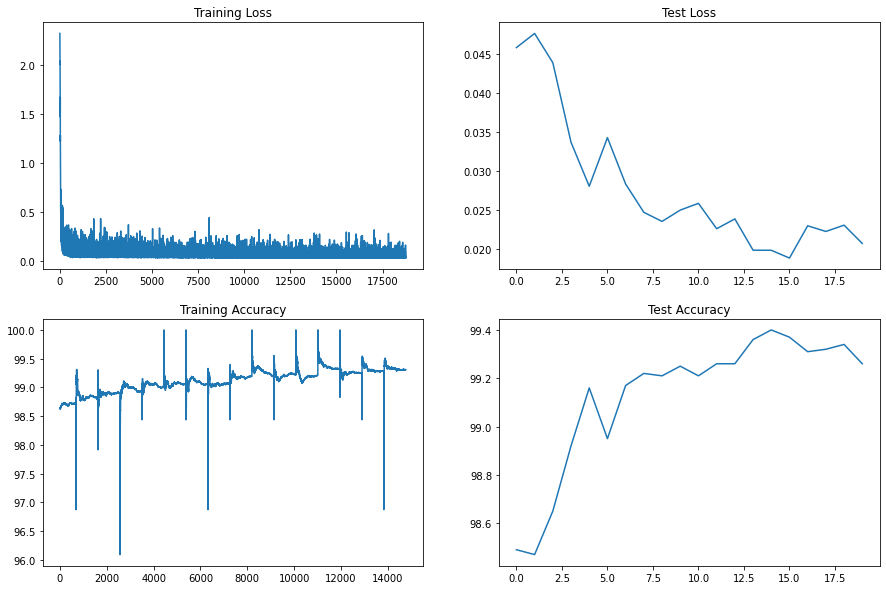

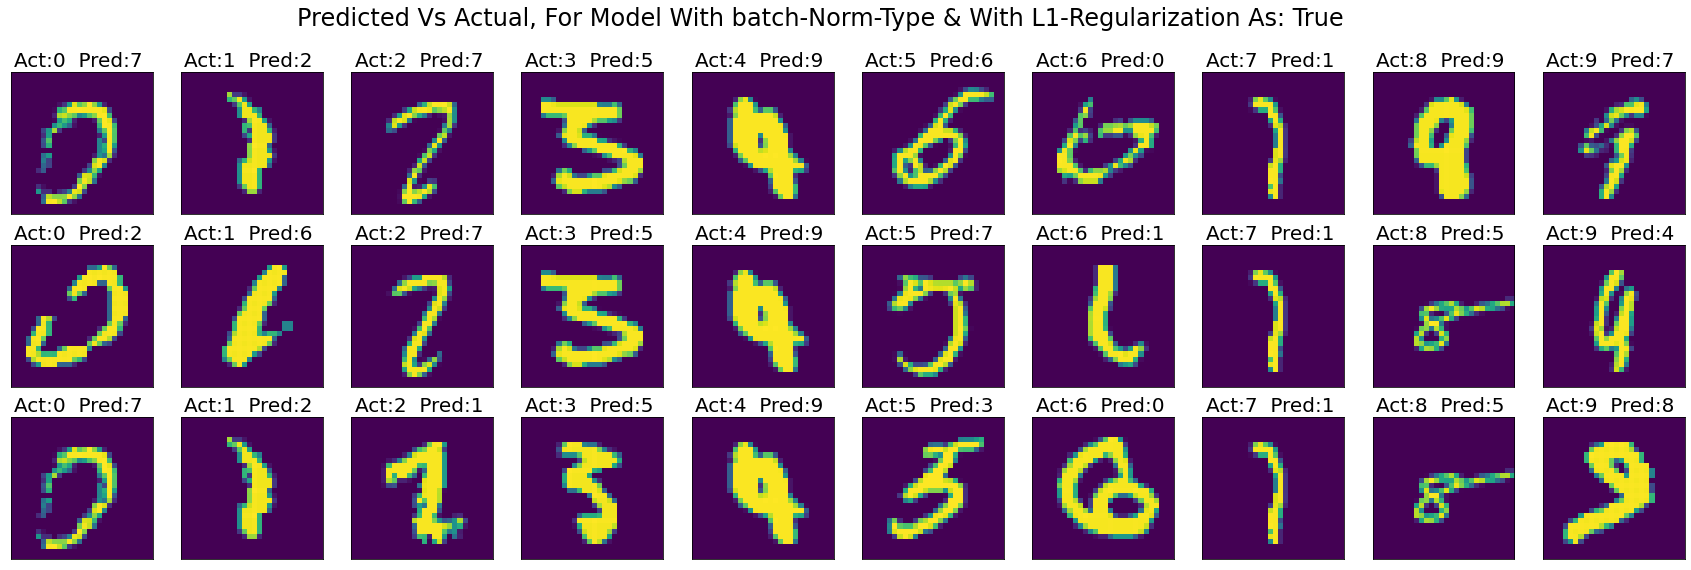

In [ ]:
device = torch.device("cuda" if cuda else "cpu")
mdl = model # The one which was imported: from session_5.modular.models import model
for i, (Norm, L1) in enumerate(run_combinations_dict.items()):
  print(f"\n\t\t\tITERATION NO: {i+1}: Norm={Norm}, L1={L1}") 
  print('\n', device)
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  best_acc1 = 0
  tmp_best_acc1 = 0
  perform_iteration_tasks(device, mdl, Norm, L1)

### Plot 2 consolidated curves: one with test accuracies & another with test-loss for all above 3 cases.


loading test_loss related numpy file from /content/saved_data/test_loss_l1_0_group-Norm.npy

loading test_acc related numpy file from /content/saved_data/test_acc_l1_0_group-Norm.npy

loading test_loss related numpy file from /content/saved_data/test_loss_l1_0_layer-Norm.npy

loading test_acc related numpy file from /content/saved_data/test_acc_l1_0_layer-Norm.npy

loading test_loss related numpy file from /content/saved_data/test_loss_l1_1_batch-Norm.npy

loading test_acc related numpy file from /content/saved_data/test_acc_l1_1_batch-Norm.npy


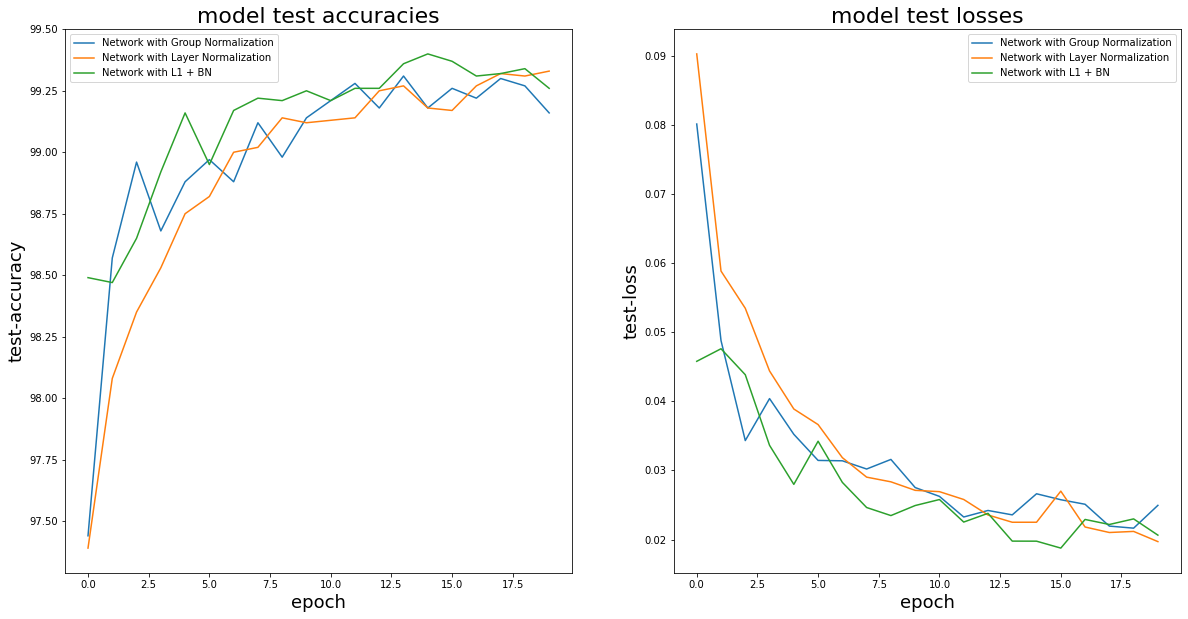

In [ ]:
test_loss = []
test_acc = []
for L1 in [False, True]:
    for Norm in ['group', 'layer', 'batch']:
        if ((L1==False)&(Norm=='batch'))or((L1==True)&(Norm=='group'))or((L1==True)&(Norm=='layer')):
          continue
        test_loss_l1_Norm, test_acc_l1_Norm = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_{}-Norm.npy'.format(int(L1), Norm),
                                                         test_acc_file_name='test_acc_l1_{}_{}-Norm.npy'.format(int(L1), Norm)
                                                         )
        test_loss.append(test_loss_l1_Norm)
        test_acc.append(test_acc_l1_Norm)

plot_curves(test_acc[0], test_acc[1], test_acc[2], test_loss[0], test_loss[1], test_loss[2])